# CAP 6615 Neural Networks Programming Assignment 3 – Recurrent Neural Network

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [1]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Step 1 - Design and build a dataset for RNN model

### Select S&P500 Dataset and Schiller P/E ratio. Make an overlay of the Schiller P/E from 1 Jan 1960 to 31 Dec 2020, onto the S&P500 for the same period.

In [2]:
# read sp500 price data and schiller pe data.
price_new=pd.read_csv('HistoricalPrices.csv')
price_old=pd.read_csv('HistoricalPrices_old.csv')
pe=pd.read_csv('ie_data_PE_full.csv')

In [3]:
pe

,Date,PE_CAPE
0,1960.01,18.338285
1,1960.02,17.545275
2,1960.03,17.286021
3,1960.04,17.429767
4,1960.05,17.256171
...,...,...
727,2020.08,31.152309
728,2020.09,30.833593
729,2020.10,31.277783
730,2020.11,32.471647


In [4]:
price_old = price_old.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_old['Date'] = pd.to_datetime(price_old['Date'])
price_old = price_old.loc[ (price_old['Date'] < '1978-01-03') &  (price_old['Date']  >= '1960-01-01' )]
price_old

,Date,Open,High,Low,Close
2511,1960-01-04,59.910000,59.910000,59.910000,59.910000
2512,1960-01-05,60.389999,60.389999,60.389999,60.389999
2513,1960-01-06,60.130001,60.130001,60.130001,60.130001
2514,1960-01-07,59.689999,59.689999,59.689999,59.689999
2515,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
7016,1977-12-23,93.800003,94.989998,93.750000,94.690002
7017,1977-12-27,94.690002,95.209999,94.089996,94.690002
7018,1977-12-28,94.690002,95.199997,93.989998,94.750000
7019,1977-12-29,94.750000,95.430000,94.099998,94.940002


In [5]:
price_old.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [6]:
price_new['Date'] = pd.to_datetime(price_new['Date'])
#reverse the dataset
price_new = price_new.iloc[::-1].reset_index(drop = True)
price_new. columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_new

,Date,Open,High,Low,Close
0,1978-01-03,93.82,95.15,93.49,93.82
1,1978-01-04,93.52,94.10,93.16,93.52
2,1978-01-05,92.74,94.53,92.51,92.74
3,1978-01-06,91.62,92.66,91.05,91.62
4,1978-01-09,90.64,91.52,90.01,90.64
...,...,...,...,...,...
10839,2020-12-24,3694.03,3703.82,3689.32,3703.06
10840,2020-12-28,3723.03,3740.51,3723.03,3735.36
10841,2020-12-29,3750.01,3756.12,3723.31,3727.04
10842,2020-12-30,3736.19,3744.63,3730.21,3732.04


In [7]:
frames = [price_old, price_new]
price = pd.concat(frames).reset_index(drop = True)
price

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000


In [8]:
pe=pe.rename({'Date':'Date_PE'},axis=1)
pe

,Date_PE,PE_CAPE
0,1960.01,18.338285
1,1960.02,17.545275
2,1960.03,17.286021
3,1960.04,17.429767
4,1960.05,17.256171
...,...,...
727,2020.08,31.152309
728,2020.09,30.833593
729,2020.10,31.277783
730,2020.11,32.471647


In [9]:
price

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000


In [10]:
i = 0
month = price['Date'][i].month
month
year = price['Date'][i].year
year

1960

In [11]:
price['Date_PE']=0.0
for i in range(price.shape[0]):
#     month=int(price['Date'][i][0:2])
#     year=int(price['Date'][i][-2:])
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01

In [12]:
price

,Date,Open,High,Low,Close,Date_PE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,1960.01
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,1960.01
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,1960.01
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,1960.01
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,1960.01
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,2020.12
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,2020.12
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,2020.12
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,2020.12


In [13]:
# merge sp500 data with the Schiller P/E ratio based on Date.
data_full = pd.merge(price, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)

In [14]:
# save the merged dataset
data_full.to_csv('Price_PE.csv')

In [15]:
data_full

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,33.769789
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,33.769789
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,33.769789
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,33.769789


### Make an overlay of the Schiller P/E onto the S&P500 for the same period.

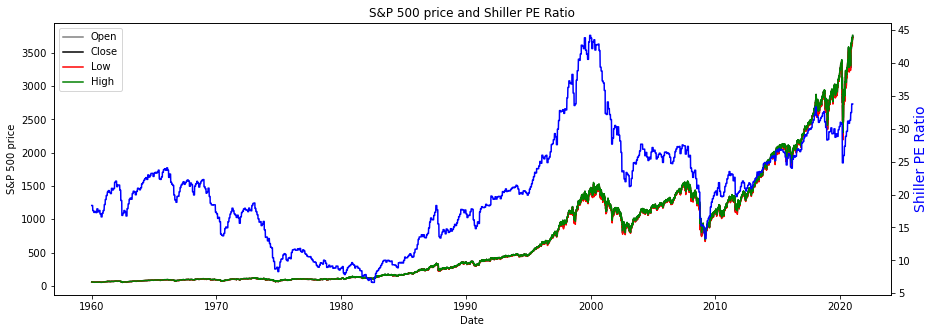

In [16]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Open.values, color='grey', label='Open')
plt.plot(data_full.Date, data_full.Close.values, color='black', label='Close')
plt.plot(data_full.Date, data_full.Low.values, color='red', label='Low')
plt.plot(data_full.Date, data_full.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio",color="blue",fontsize=14)
plt.show()

#### Here, we are only using ClOSE price and Cyclicily adjusted PE-ratio to train the model

In [17]:
dataset = data_full[ ['Close', 'PE_CAPE']].values
dataset

array([[  59.91      ,   18.33828499],
       [  60.389999  ,   18.33828499],
       [  60.130001  ,   18.33828499],
       ...,
       [3727.04      ,   33.76978942],
       [3732.04      ,   33.76978942],
       [3756.07      ,   33.76978942]])

### From Schiller P/E report analysis, we use PE ratio to "hint" about the RNN according to its price state and add this as a new data column
### refer https://www.longtermtrends.net/sp500-price-earnings-shiller-pe-ratio/

In [18]:
# '5' indicates stocks are extremely undervalued
# '4' indicates stocks are undervalued
# '3' indicates stocks are fair
# '2' indicatehttp://localhost:8888/notebooks/PycharmProjects/NNp/CAP6166/HW3/Assignment3-updated.ipynb#s stocks are overvalued
# '1' indicates stocks are in a bubble
# '0' indicates stocks are in an extreme bubble
def checkPEState(pe_ratio):
    state = 0
    if pe_ratio < 7.5:
        state = 5
    elif pe_ratio >= 7.5 and pe_ratio < 12.75:
        state = 4
    elif pe_ratio >= 12.75 and pe_ratio < 15:
        state = 3
    elif pe_ratio >= 15 and pe_ratio < 20:
        state = 2
    elif pe_ratio >= 20 and pe_ratio < 25:
        state = 1
    elif pe_ratio >= 25:
        state = 0
    return state

In [19]:
dataset = np.append(dataset,np.zeros([len(dataset),1]),1)

In [20]:
for x in dataset:
    s = checkPEState(x[1])
    x[2] = s
dataset

array([[5.99100000e+01, 1.83382850e+01, 2.00000000e+00],
       [6.03899990e+01, 1.83382850e+01, 2.00000000e+00],
       [6.01300010e+01, 1.83382850e+01, 2.00000000e+00],
       ...,
       [3.72704000e+03, 3.37697894e+01, 0.00000000e+00],
       [3.73204000e+03, 3.37697894e+01, 0.00000000e+00],
       [3.75607000e+03, 3.37697894e+01, 0.00000000e+00]])

In [21]:
date_data= data_full[ ['Date']].values

In [22]:
# Feature Scaling: min-max normalization of features
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.31149771, 0.4       ],
       [0.0022112 , 0.31149771, 0.4       ],
       [0.002141  , 0.31149771, 0.4       ],
       ...,
       [0.99216225, 0.72235494, 0.        ],
       [0.99351219, 0.72235494, 0.        ],
       [1.        , 0.72235494, 0.        ]])

In [23]:
dataset.shape

(15354, 3)

In [24]:
# number of timepoint and number of feature
n_rows, n_cols = dataset_scaled.shape
(n_rows,n_cols)

(15354, 3)

#### The S&P 500 index increases in time, bringing about the problem that most values in the test set are out of the scale of the train set and thus the model has to predict some numbers it has never seen before.

## Step 2 - Design and develop RNN in Python, using libraries such as PyTorch (and, if necessary, Tensor Flow). 

In [25]:
#Data format setting
# The number of expected features in the input x is 3
input_size = 3
hidden_size = 16
num_layers = 3
output_size = 4
num_epochs = 100
learning_rate = 0.001
# sequence length is 180
window_size = 180

In [26]:
# Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+window_size+output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [27]:
X_full.shape

(15171, 180, 3)

In [28]:
y_full.shape

(15171, 1, 4)

In [29]:
date_full

array([['1960-09-19T00:00:00.000000000'],
       ['1960-09-20T00:00:00.000000000'],
       ['1960-09-21T00:00:00.000000000'],
       ...,
       ['2020-12-23T00:00:00.000000000'],
       ['2020-12-24T00:00:00.000000000'],
       ['2020-12-28T00:00:00.000000000']], dtype='datetime64[ns]')

### The NYSE and NASDAQ average about 253 trading days a year. We use 10\% for testing, i.e. first 200 days for training, and consecutive 53 datapoints for testing.

In [30]:
X_train = []; y_train = []; date_train = []
X_test = []; y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        y_test.append(y_full[i])
        date_test.append(date_full[i])
    else:
        X_train.append(X_full[i])
        y_train.append(y_full[i])
        date_train.append(date_full[i])
X_train, y_train, date_train = np.array(X_train), np.array(y_train), np.array(date_train)          
X_test, y_test, date_test = np.array(X_test), np.array(y_test), np.array(date_test)                

In [31]:
# Input shape --> (Sequence Length, Batch Size, Input Size)
X_train.shape

(12000, 180, 3)

In [32]:
X_test.shape

(3171, 180, 3)

In [33]:
y_train.shape

(12000, 1, 4)

In [34]:
y_test.shape

(3171, 1, 4)

In [35]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
#         out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        #just want last time step output 
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [36]:
rnn = Model (input_size, output_size, hidden_size, num_layers)
#set the model to the device that we defined earlier (default is CPU)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [37]:
rnn

Model(
  (rnn): RNN(3, 16, num_layers=3, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

## Step 3 - Train your RNN using time window 180

In [38]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden = rnn(inputs) 
    
    loss = criterion(output.reshape(-1), labels.view(-1))
    print("Epoch ", epoch, "MSE: ", loss.item())
    optimiser.zero_grad()

    # Backward pass
    loss.backward(retain_graph=True)

    # Update parameters
    optimiser.step()                                


Epoch  0 MSE:  0.07948334515094757
Epoch  1 MSE:  0.0740831196308136
Epoch  2 MSE:  0.0691789761185646
Epoch  3 MSE:  0.06469358503818512
Epoch  4 MSE:  0.060589659959077835
Epoch  5 MSE:  0.056851718574762344
Epoch  6 MSE:  0.05347331240773201
Epoch  7 MSE:  0.05045141652226448
Epoch  8 MSE:  0.047782428562641144
Epoch  9 MSE:  0.045459527522325516
Epoch  10 MSE:  0.04347147047519684
Epoch  11 MSE:  0.041798561811447144
Epoch  12 MSE:  0.04040570557117462
Epoch  13 MSE:  0.039236363023519516
Epoch  14 MSE:  0.03821401670575142
Epoch  15 MSE:  0.03725253418087959
Epoch  16 MSE:  0.03627092018723488
Epoch  17 MSE:  0.03520754352211952
Epoch  18 MSE:  0.034030165523290634
Epoch  19 MSE:  0.032739412039518356
Epoch  20 MSE:  0.03136434033513069
Epoch  21 MSE:  0.029950948432087898
Epoch  22 MSE:  0.02854710817337036
Epoch  23 MSE:  0.027188574895262718
Epoch  24 MSE:  0.02588985115289688
Epoch  25 MSE:  0.024642832577228546
Epoch  26 MSE:  0.023425333201885223
Epoch  27 MSE:  0.0222174432

In [39]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], output.detach().numpy()[:, [0]],output.detach().numpy()[:, [0]]), axis=1)
out_temp.shape
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
predicted_price

array([[   8.112866 ],
       [   7.8147197],
       [   7.432791 ],
       ...,
       [2847.267    ],
       [2845.7097   ],
       [2844.593    ]], dtype=float32)

In [40]:
predicted_price.shape

(12000, 1)

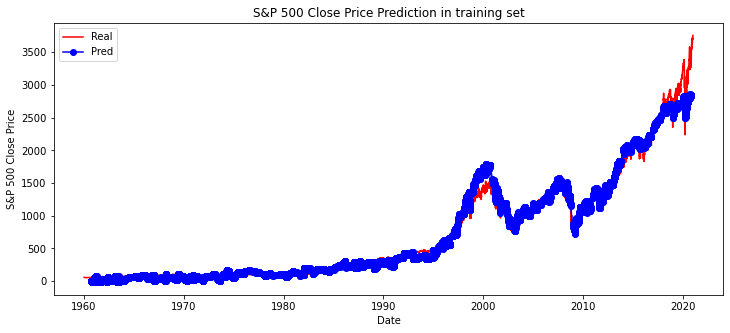

In [41]:
# Visualising the results in training dataset
plt.figure(1, figsize=(12, 5))
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_train,predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [42]:
# compute prediction_error := (predicted_price - actual_price) / actual_price 
def prediction_error(target, pred):
    error = abs(pred - target)/target
    return error

In [43]:
out_temp = np.concatenate( (y_train[:, :, 0], y_train[:, :, 0], y_train[:, :, 0]), axis = 1)
target_train = sc.inverse_transform(out_temp)[:, [0]]
error = prediction_error(target_train, predicted_price)

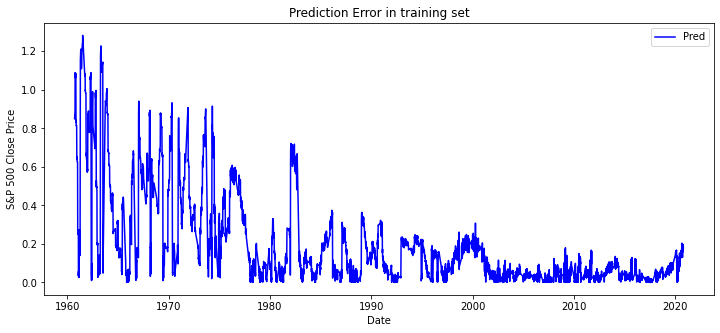

In [44]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_train, error, color = 'blue', label = 'Pred')
plt.title('Prediction Error in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

## Step 4 - Test your RNN accuracy in predicting the next one, two, three, and four datapoints in the dataset from 1 Jan 1980 through the present day, using a sliding sampling window of width 180 days. 

In [45]:
X_test.shape

(3171, 180, 3)

In [46]:
y_test.shape

(3171, 1, 4)

In [47]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
output_test.shape

torch.Size([3171, 4])

In [48]:
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], output_test.detach().numpy()[:, [0]], output_test.detach().numpy()[:, [0]]), axis=1)
out_temp.shape

(3171, 3)

In [49]:
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
predicted_price_test

array([[ -13.081896],
       [ -13.051679],
       [ -12.655731],
       ...,
       [2905.1145  ],
       [2904.57    ],
       [2904.5984  ]], dtype=float32)

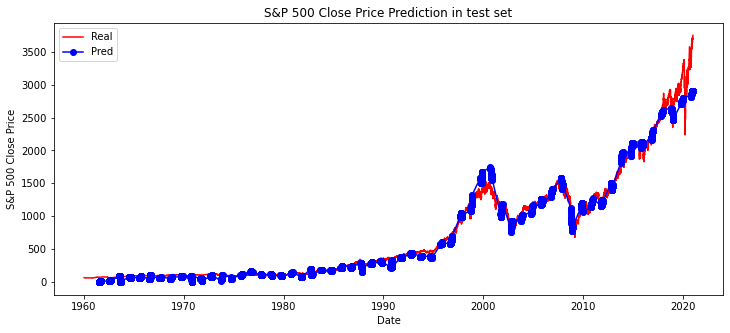

In [50]:
# Visualising the results in test dataset
plt.figure(1, figsize=(12, 5))
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [51]:
out_temp = np.concatenate( (y_test[:, :, 0], y_test[:, :, 0], y_test[:, :, 0]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error = prediction_error(target_test, predicted_price_test)
error

array([[1.1989037 ],
       [1.19862546],
       [1.19265841],
       ...,
       [0.21270823],
       [0.21562976],
       [0.2224047 ]])

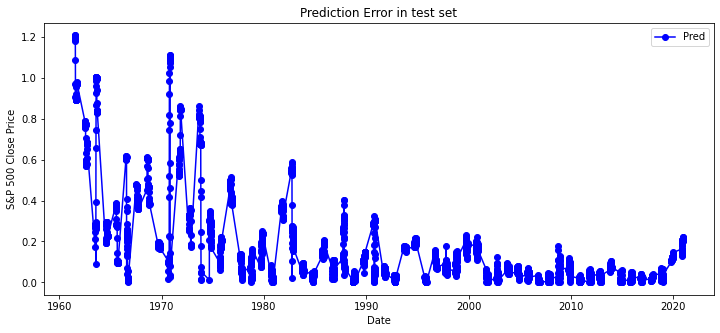

In [52]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test, error, color = 'blue', label = 'Pred', marker= 'o')
plt.title('Prediction Error in test set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

## Step 5 - Optimize your RNN performance to yield maximum achievable accuracy (e.g., minimum predicted_error) over the entire Training Set and Test Set.  Repeat Step 4 graphing operation to show this optimized result.

In [53]:
#decrease the number layer from 3 to 2 to avoid overfitting
#iecrease hidden unit size from 16 to 32 
input_size = 3
hidden_size = 32
num_layers = 2
output_size = 4
num_epochs = 100
learning_rate = 0.001
# sequence length is 180
window_size = 180

In [54]:
rnn = Model (input_size, output_size, hidden_size, num_layers)
#set the model to the device that we defined earlier (default is CPU)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [55]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden = rnn(inputs) 
    
    loss = criterion(output.reshape(-1), labels.view(-1))
    print("Epoch ", epoch, "MSE: ", loss.item())
    optimiser.zero_grad()

    # Backward pass
    loss.backward(retain_graph=True)

    # Update parameters
    optimiser.step()        

Epoch  0 MSE:  0.08468567579984665
Epoch  1 MSE:  0.072496198117733
Epoch  2 MSE:  0.0631028264760971
Epoch  3 MSE:  0.0560111477971077
Epoch  4 MSE:  0.05088196322321892
Epoch  5 MSE:  0.047350239008665085
Epoch  6 MSE:  0.044990818947553635
Epoch  7 MSE:  0.043360549956560135
Epoch  8 MSE:  0.042074497789144516
Epoch  9 MSE:  0.040884315967559814
Epoch  10 MSE:  0.03968971595168114
Epoch  11 MSE:  0.03847576305270195
Epoch  12 MSE:  0.03723158314824104
Epoch  13 MSE:  0.035908110439777374
Epoch  14 MSE:  0.03442752733826637
Epoch  15 MSE:  0.032711904495954514
Epoch  16 MSE:  0.03070535697042942
Epoch  17 MSE:  0.02838774584233761
Epoch  18 MSE:  0.025784097611904144
Epoch  19 MSE:  0.022969773039221764
Epoch  20 MSE:  0.020067492499947548
Epoch  21 MSE:  0.01722964271903038
Epoch  22 MSE:  0.014601049944758415
Epoch  23 MSE:  0.012282483279705048
Epoch  24 MSE:  0.010365456342697144
Epoch  25 MSE:  0.009076525457203388
Epoch  26 MSE:  0.008828448131680489
Epoch  27 MSE:  0.009669200

In [56]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
output_test.shape

torch.Size([3171, 4])

In [57]:
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], output_test.detach().numpy()[:, [0]], output_test.detach().numpy()[:, [0]]), axis=1)
out_temp.shape

(3171, 3)

In [58]:
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
predicted_price_test

array([[  30.068989],
       [  30.750196],
       [  31.333464],
       ...,
       [3086.4077  ],
       [3085.4954  ],
       [3085.297   ]], dtype=float32)

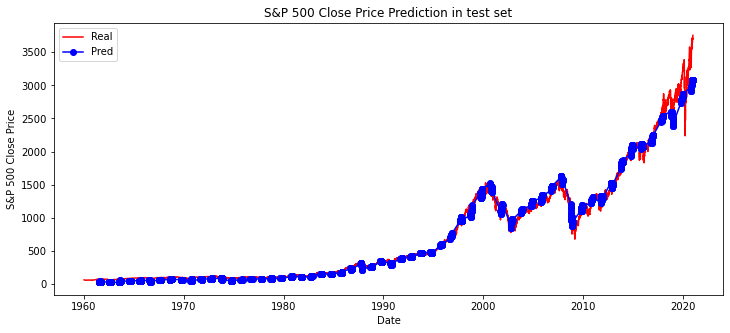

In [59]:
# Visualising the results in test dataset
plt.figure(1, figsize=(12, 5))
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

## Step 6 -  Corrupt your Test Set (from 1), above) by adding noise

In [60]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, index, 0] = dataset_noise[i, index, 0] + s
#         dataset_noise[i, 0] = NormalizeData(dataset_noise[i,0 ])
    return dataset_noise   

In [63]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], output_test.detach().numpy()[:, [0]],  output_test.detach().numpy()[:, [0]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [64]:
error.shape

(3171, 1)

In [65]:
labels = date_test[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T

In [66]:
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-07,0.542816,0.542760,0.542759,0.542689,0.542801,0.542602,0.541895,0.542292,0.543467,0.542788
1961-07-10,0.532032,0.527578,0.569716,0.540101,0.552089,0.460614,0.122078,0.259230,0.529302,0.330611
1961-07-11,0.523010,0.529286,0.521744,0.525969,0.535340,0.514851,0.487151,0.505173,0.538642,0.578404
1961-07-12,0.515947,0.517026,0.516608,0.518401,0.510905,0.527308,0.525557,0.491709,0.595151,0.437100
1961-07-13,0.510026,0.510085,0.496413,0.538658,0.504244,0.600330,0.246564,0.544535,0.265264,0.874790
...,...,...,...,...,...,...,...,...,...,...
2020-12-21,0.165232,0.165187,0.165309,0.165161,0.165153,0.164972,0.164763,0.168361,0.163947,0.171241
2020-12-22,0.162946,0.163112,0.163184,0.162922,0.163473,0.161833,0.164648,0.170160,0.172755,0.158554
2020-12-23,0.163577,0.163606,0.163554,0.163715,0.163949,0.163604,0.162955,0.164063,0.168279,0.177755
2020-12-24,0.166771,0.166806,0.166813,0.166744,0.166654,0.166937,0.166906,0.166536,0.164849,0.164632


In [67]:
# max(error_res_all[9])

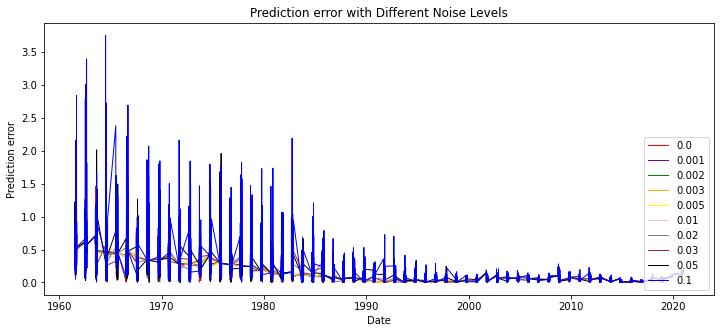

In [68]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(12, 5))
for i in range(len(sd)):    
    plt.plot(date_test, error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
plt.xlabel('Date')
plt.ylabel('Prediction error')
plt.title('Prediction error with Different Noise Levels')
plt.legend(loc="lower right")  

In [ ]:
#reference:https://github.com/thundercomb/pytorch-stock-predictor-rnn/blob/master/pytorch-stock-predictor-lstm.ipynb